# Suicide Detection 

The CSV file contains the data collected from the reddit threads r/suicide, r/depression, r/SuicideWatch and r/teenager. Here, Data from the r/teenager is labeled as 'non-suicide' and data from the other threads are marked as 'suicide' as it closely linked to the suicidal symptoms. Thanks to nikhileswar komati (check his kaggle account) for providing the data.

In [1]:
#Importing libraries
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
import unicodedata 
#from contractions import CONTRACTION_MAP # from contractions.py
import contractions
import re
import nltk
import string 
import spacy
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import word_tokenize
from pickle import dump
from collections import Counter
from nltk import ngrams
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /Users/Sudarshan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!python -m nltk.downloader stopwords

/opt/anaconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sudarshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Reading the columns
data = pd.read_csv('./Suicide_Detection.csv')
data.head()


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data.info()
#Check if there is any missing values
data.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


0

Now, Lets check how many texts are marked as 'suicide' and how many of them are marked as 'non-suicide' to make sure that there is no class imbalanace.

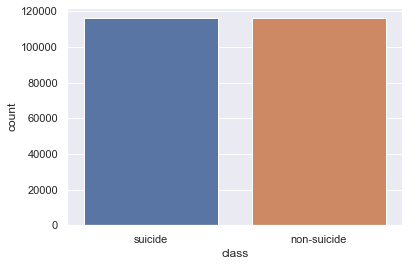

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="class", data=data)

In [ ]:
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

def expand_contractions(text):
    new_text = contractions.fix(text)
    return new_text


def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

nlp = spacy.load('en_core_web_sm')
def get_lem(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# custom: removing words from list
stopword_list.remove('not')
# function to remove stopwords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text

def remove_extra_whitespace_tabs(text):
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def to_lowercase(text):
    return text.lower()


data['text'] = data['text'].apply(remove_accented_chars).apply(expand_contractions).apply(remove_special_characters).apply(remove_numbers).apply(remove_punctuation).apply(get_lem).apply(remove_stopwords).apply(remove_extra_whitespace_tabs).apply(to_lowercase)
#data.to_pickle('./processed_data.pkl')

In [2]:
data = pd.read_pickle("./processed_data.pkl")
data = data.rename(columns={'class': 'class_name'})
data.head()
data_suicidal = data[data.class_name.eq("suicide")]
data_not_suicidal = data[data.class_name.eq("non-suicide")]

In [9]:
data.count()

Unnamed: 0    232074
text          232074
class_name    232074
dtype: int64

Checking for patterns in the 'suicide'  labled data

In [13]:
def word_freq_plot(sentence):
    new_tokens = word_tokenize(sentence)
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams
concat_s =  data_suicidal["text"].str.cat(sep =" ")
word_freq_s,word_pairs_s,trigrams_s = word_freq_plot(concat_s)

concat_ns =  data_not_suicidal["text"].str.cat(sep =" ")
word_freq_ns,word_pairs_ns,trigrams_ns = word_freq_plot(concat_ns)

Calculate the word frequency of the suicidal DataSet

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

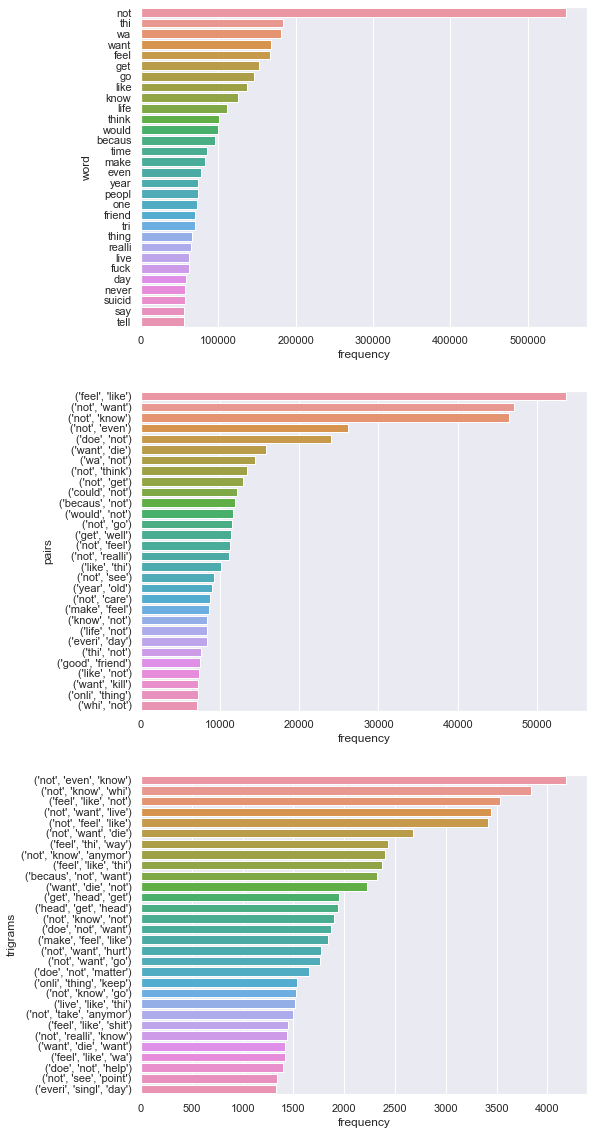

In [14]:
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_s.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs_s.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams_s.head(30))

Calculate the word frequency of the non suicidal DataSet

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

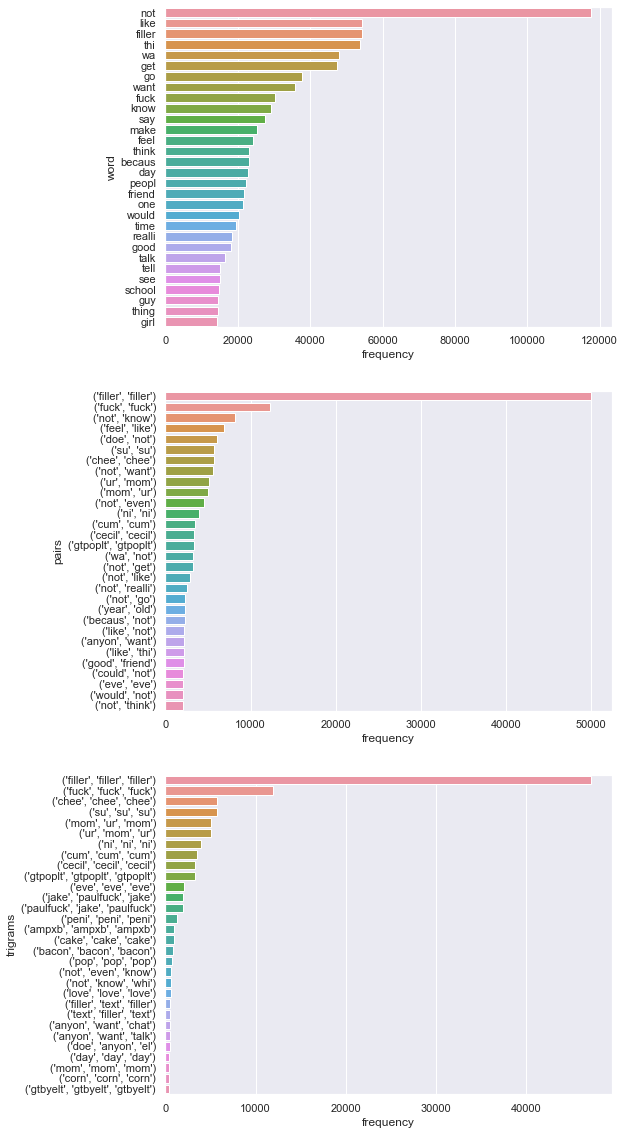

In [15]:
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_ns.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs_ns.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams_ns.head(30))

# Observations:
From word frequency plot:
1) In both datasets, word 'not' usage is very high. But, Its significantly higher in 'suicide' compared to 'non-   suicide' labeled dataset.

2) One interesting observation in 'suicide' labeled dataset is, words like 'suicide', 'kill', 'die' are not mentioned frequently.

From pairs and trigrams:
1) Most of the pairs and trigrams obtained from the 'suicide' dataset expresses negative connotations. Nothing surprising.
2) One more observation is, 'non-suicidal' dataset is showing more repeated words, whereas words in 'suicide' dataset is well formed. Thread title (r/teenager) used for the 'non-suicidal' dataset explains everything. I think it may not be the right choice. Anyways, lets continue..


In [ ]:
Lets count the number of words per row and compare.

In [3]:
data_suicidal['totalwords'] = data_suicidal['text'].str.split().str.len().tolist()
data_not_suicidal['totalwords'] = data_not_suicidal['text'].str.split().str.len()
print(data_not_suicidal['totalwords'])

<ipython-input-3-e446dabf94bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_suicidal['totalwords'] = data_suicidal['text'].str.split().str.len().tolist()


1         14
2         12
8         94
15        14
17        11
          ..
232068    16
232069    10
232070    14
232071    12
232073    18
Name: totalwords, Length: 116037, dtype: int64


<ipython-input-3-e446dabf94bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_suicidal['totalwords'] = data_not_suicidal['text'].str.split().str.len()


5717 3873


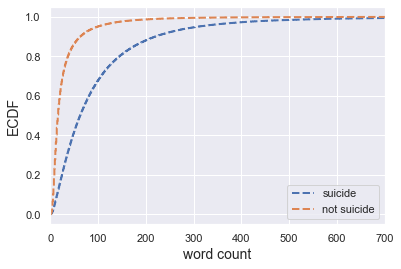

In [17]:
import dc_stat_think as dcst
arr_ns = data_not_suicidal['totalwords'].tolist()
arr_s = data_suicidal['totalwords'].tolist()
print(max(arr_ns),max(arr_s))
x_ns,y_ns = dcst.ecdf(arr_ns)
x_s,y_s = dcst.ecdf(arr_s)
plt.plot(x_s, y_s, linestyle='--', lw = 2)
plt.plot(x_ns, y_ns, linestyle='--', lw = 2)
plt.legend(("suicide", "not suicide"))
plt.xlabel('word count', size = 14)
plt.ylabel('ECDF', size = 14)
plt.xlim([0, 700])
plt.show()

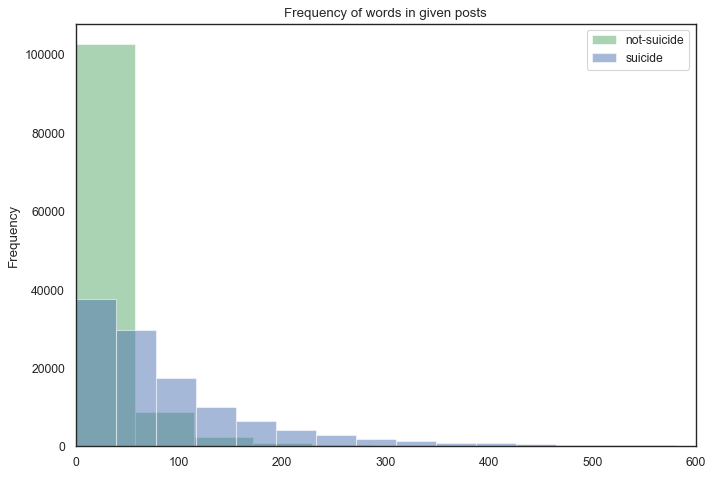

In [18]:
sns.set_style("white")
kwargs =  dict(alpha=0.5, bins=100)

plt.figure(figsize=(10,7), dpi= 80)
plt.hist(arr_ns, **kwargs, color='g', label='not-suicide')
plt.hist(arr_s, **kwargs, color='b', label='suicide')
plt.gca().set(title='Frequency of words in given posts', ylabel='Frequency')
plt.xlim(0,600)
plt.legend();

# Now, perform text classification using glove embeddings.

In [4]:
X = data['text']
y = data['class_name']
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_train_tokeniser = tokenizer.texts_to_sequences(X_train)
X_test_tokeniser = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_tokeniser,maxlen=50)
X_test_padded = pad_sequences(X_test_tokeniser,maxlen=50)
word_index = tokenizer.word_index

In [5]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(y_train)
test_output=lbl_target.fit_transform(y_test)

In [6]:
len(X_test_padded)


46415

In [7]:
len(test_output)

46415

In [8]:
len(tokenizer.word_index)

165654

In [11]:
embeddings_index = {}
# glove_embedding={}
with open('../../glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)
v=len(tokenizer.word_index)
print(v)
embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

165654


In [12]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [13]:
v

165654

In [44]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True,dropout = 0.1, recurrent_dropout = 0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer= optimizer, loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall'])

In [35]:
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, concatenate
from keras.layers import Bidirectional,Activation,Conv1D,GRU
from keras.models import Model

sequence_input = Input(shape=(50,))
x = Embedding(len(word_index)+1,300, weights=[embedding_matrix],trainable = False)(sequence_input)
#x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(64, activation='relu')(x)
#x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall'])

In [45]:
r=model.fit(X_train_padded,train_output,validation_data=(X_test_padded,test_output),
            epochs=20,batch_size=256)

Epoch 1/20
726/726 [==============================] - 150s 202ms/step - loss: 0.2337 - accuracy: 0.9067 - precision: 0.9036 - recall: 0.9109 - val_loss: 0.1934 - val_accuracy: 0.9233 - val_precision: 0.9214 - val_recall: 0.9249
Epoch 2/20
726/726 [==============================] - 147s 203ms/step - loss: 0.1919 - accuracy: 0.9252 - precision: 0.9218 - recall: 0.9294 - val_loss: 0.1861 - val_accuracy: 0.9274 - val_precision: 0.9319 - val_recall: 0.9217
Epoch 3/20
726/726 [==============================] - 150s 207ms/step - loss: 0.1827 - accuracy: 0.9290 - precision: 0.9250 - recall: 0.9338 - val_loss: 0.1849 - val_accuracy: 0.9281 - val_precision: 0.9256 - val_recall: 0.9305
Epoch 4/20
726/726 [==============================] - 149s 206ms/step - loss: 0.1770 - accuracy: 0.9318 - precision: 0.9274 - recall: 0.9370 - val_loss: 0.1874 - val_accuracy: 0.9258 - val_precision: 0.9089 - val_recall: 0.9459
Epoch 5/20
726/726 [==============================] - 148s 204ms/step - loss: 0.1737 - a

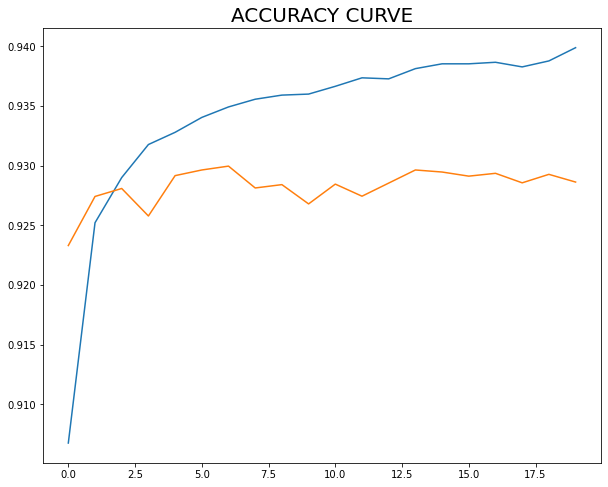

In [46]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

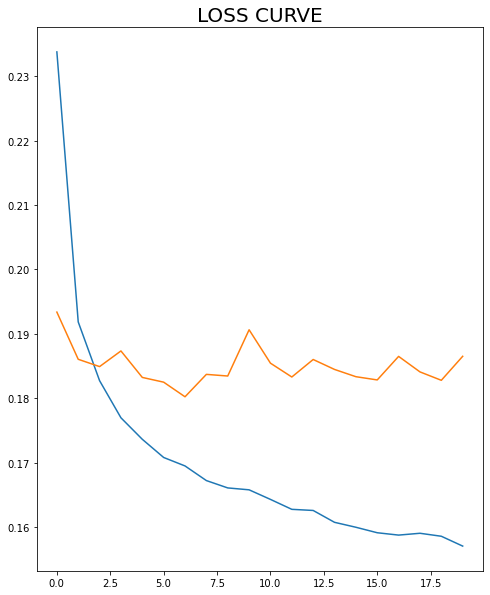

In [47]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()